In [ ]:
import requests
import pandas as pd

# 我先做了DC的 因为数据多
# API 请求参数
base_url = "https://www.ncei.noaa.gov/access/services/data/v1"
params = {
    "dataset": "daily-summaries",
    "stations": "USW00013743",  # 请先查找相应地区的站点 ID
    "startDate": "1921-01-01",
    "endDate": "2025-02-18",
    "format": "json"
}

# 发送请求
response = requests.get(base_url, params=params)

if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data)

df

DATE      STATION   TAVG   SNOW   TMAX   TMIN   PRCP   SNWD WT03  \
0      1936-09-01  USW00013743    245    NaN    NaN    NaN    NaN    NaN  NaN   
1      1936-09-02  USW00013743    224    NaN    NaN    NaN    NaN    NaN  NaN   
2      1936-09-03  USW00013743    233    NaN    NaN    NaN    NaN    NaN  NaN   
3      1936-09-04  USW00013743    239    NaN    NaN    NaN    NaN    NaN  NaN   
4      1936-09-05  USW00013743    233    NaN    NaN    NaN    NaN    NaN  NaN   
...           ...          ...    ...    ...    ...    ...    ...    ...  ...   
32308  2025-02-14  USW00013743     38      0     67      6      0      0  NaN   
32309  2025-02-15  USW00013743     31      0     50     17    119      0  NaN   
32310  2025-02-16  USW00013743     77      0    189     39    119      0  NaN   
32311  2025-02-17  USW00013743     39      0     67      0      0      0  NaN   
32312  2025-02-18  USW00013743      2      0     33    -49      0      0  NaN   

      WT16  ... WT11 WT10 WT19 RHMX ASLP RHAV ASTP RHMN AWBT ADPT  
0      NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1      NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2      NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3      NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4      NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
32308  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
32309  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
32310  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
32311  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
32312  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[32313 rows x 56 columns]

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [ ]:
# ========== 读取气象数据 ==========
df_weather = df
df_weather["DATE"] = pd.to_datetime(df_weather["DATE"])
df_weather["year"] = df_weather["DATE"].dt.year
df_weather["DOY"]  = df_weather["DATE"].dt.dayofyear
df_weather = df_weather[df_weather["DOY"] <= 110].copy()
df_weather = df_weather[df_weather["DOY"] >= 70].copy()

# 需要的特征列（可酌情添加RH、WS等更多气象要素）
FEATURE_COLS = ["TMAX", "TMIN", "TAVG", "PRCP", "SNOW"]

# 保证数值类型
for col in FEATURE_COLS:
    df_weather[col] = pd.to_numeric(df_weather[col], errors="coerce")

# ========== 读取樱花数据 ==========
df_bloom = pd.read_csv("washingtondc.csv")
df_bloom["bloom_date"] = pd.to_datetime(df_bloom["bloom_date"])
# bloom_doy: 当年开花的 DOY
df_bloom = df_bloom[["year", "bloom_date", "bloom_doy"]]

In [ ]:
WINDOW_SIZE = 10  # 滑窗天数
MAX_LABEL   = 50

def create_sliding_window_samples(df_weather, df_bloom, feature_cols, window_size, max_label):
    X_list = []
    y_list = []

    # 逐年处理
    years = sorted(df_weather["year"].unique())
    for y in years:
        # 当年气象
        sub_weather = df_weather[df_weather["year"] == y].sort_values("DOY")
        if len(sub_weather) < window_size:
            continue  # 数据太少

        # 当年盛开日
        bloom_info = df_bloom[df_bloom["year"] == y]
        if bloom_info.empty:
            continue
        bloom_day = bloom_info["bloom_doy"].values[0]

        # 转成数组便于滑窗
        arr_weather = sub_weather[feature_cols].values  # shape=(N, F)
        arr_doy     = sub_weather["DOY"].values         # shape=(N, )

        # 从 day=1(或window_size) 滑动到 day=200
        # i 是 sub_weather 的行索引 0..(N-1)
        for i in range(len(sub_weather)):
            # 看是否能取到过去 window_size 天
            if i < window_size - 1:
                continue

            # 取当前日 actual_doy
            actual_doy = arr_doy[i]
            # 滑窗特征：前 window_size 天的气象 (含当天)
            seq_data = arr_weather[i-window_size+1 : i+1]  # shape=(window_size, F)

            # 计算标签 bloom_day - actual_doy
            diff = bloom_day - actual_doy
            if diff < 0:
                label = 0
            elif diff > max_label:
                label = max_label
            else:
                label = diff

            X_list.append(seq_data)
            y_list.append(label)

    X_array = np.array(X_list, dtype=np.float32)  # (samples, window_size, F)
    y_array = np.array(y_list,  dtype=np.int32)   # (samples, )
    return X_array, y_array

X, y = create_sliding_window_samples(
    df_weather, df_bloom,
    FEATURE_COLS,
    WINDOW_SIZE,
    MAX_LABEL
)

print("X shape:", X.shape)  # (样本数, 10, 5)
print("y shape:", y.shape)  # (样本数, )
print("label 分布示例:", pd.Series(y).value_counts().sort_index().head(35))


X shape: (2816, 10, 5)
y shape: (2816,)
label 分布示例: 0     1587
1       84
2       81
3       81
4       79
5       78
6       76
7       73
8       70
9       68
10      63
11      61
12      59
13      54
14      47
15      43
16      41
17      35
18      30
19      24
20      21
21      17
22      13
23      11
24       6
25       6
26       4
27       2
28       1
29       1
Name: count, dtype: int64


In [ ]:
# Attempt 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

N_tr, T, F = X_train.shape
N_te = X_test.shape[0]

# -------------------------------
# 2. Reshape -> StandardScaler
# -------------------------------
X_train_2d = X_train.reshape(N_tr * T, F)
X_test_2d  = X_test.reshape(N_te * T, F)

scaler = StandardScaler()
X_train_scaled_2d = scaler.fit_transform(X_train_2d)
X_test_scaled_2d  = scaler.transform(X_test_2d)

# -------------------------------
# 3. 删除 X_train_scaled_2d 中含 NaN 的整条序列
# -------------------------------
def remove_nan_blocks(X_scaled_2d, y, N, T, F):
    valid_blocks = []
    for i in range(N):
        block_start = i * T
        block_end   = (i+1) * T
        block = X_scaled_2d[block_start:block_end, :]

        # 若该 block 中无 NaN
        if not np.isnan(block).any():
            valid_blocks.append(i)

    M = len(valid_blocks)  # 有效样本数
    # 构建新的 2D 数组 (M*T, F)
    X_clean_2d = np.zeros((M * T, F), dtype=X_scaled_2d.dtype)
    for idx, i_block in enumerate(valid_blocks):
        src_start = i_block * T
        src_end   = src_start + T
        dst_start = idx * T
        dst_end   = dst_start + T

        # 拷贝这条序列
        X_clean_2d[dst_start:dst_end, :] = X_scaled_2d[src_start:src_end, :]

    X_clean_3d = X_clean_2d.reshape(M, T, F)
    y_clean    = y[valid_blocks]

    return X_clean_3d, y_clean

X_train_scaled, y_train = remove_nan_blocks(
    X_train_scaled_2d, y_train, N_tr, T, F
)
X_test_scaled,  y_test  = remove_nan_blocks(
    X_test_scaled_2d,  y_test,  N_te, T, F
)

In [ ]:
print("NaN in X_train_scaled:", np.isnan(X_train_scaled).any())
print("NaN in y_train:", np.isnan(y_train).any())
print("NaN in X_test_scaled:", np.isnan(X_test_scaled).any())

NaN in X_train_scaled: False
NaN in y_train: False
NaN in X_test_scaled: True


In [ ]:
# 不剔除val set缺失值 但不知为何好像结果更合理 （代替上文# Attempt 1）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ========== 标准化 ==========
N_tr, T, F = X_train.shape
X_train_2d = X_train.reshape(N_tr*T, F)

scaler = StandardScaler()
X_train_scaled_2d = scaler.fit_transform(X_train_2d)
X_train_scaled = X_train_scaled_2d.reshape(N_tr, T, F)

# 测试集
N_te = X_test.shape[0]
X_test_2d = X_test.reshape(N_te*T, F)

X_test_scaled_2d = scaler.transform(X_test_2d)
X_test_scaled = X_test_scaled_2d.reshape(N_te, T, F)

num_classes = MAX_LABEL + 1  # 类别数

# 先展平为 2D
X_train_2d = X_train.reshape(-1, X_train.shape[2])  # shape=(N * window_size, F)

# 找到非 NaN 行
valid_rows = ~np.isnan(X_train_2d).any(axis=1)

# 过滤掉 NaN
X_train_cleaned = X_train_2d[valid_rows]

# 计算新样本数 (必须是 window_size 的整数倍)
new_N = X_train_cleaned.shape[0] // X_train.shape[1]
if new_N * X_train.shape[1] != X_train_cleaned.shape[0]:
    print(f"⚠️ 警告: 清理 NaN 后，样本数不再是 {X_train.shape[1]} 的整数倍，可能导致 LSTM 训练出错！")
    new_N = new_N - 1  # 取最接近的可用样本数
    X_train_cleaned = X_train_cleaned[:new_N * X_train.shape[1]]

# 重新 reshape 回 (N, window_size, F)
X_train_scaled = X_train_cleaned.reshape(new_N, X_train.shape[1], X_train.shape[2])

# 同步 y_train
y_train = y_train[:new_N]



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 一个简单的模型 肯定还要调参
model = Sequential()
model.add(LSTM(
    units=32,
    return_sequences=False,
    input_shape=(WINDOW_SIZE, len(FEATURE_COLS)),
    activation="tanh"
))
# 也可以再加一层 LSTM 或 Dense:
# model.add(LSTM(16, return_sequences=False, activation="tanh"))
model.add(Dense(num_classes, activation="softmax"))

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 32)                  │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 51)                  │           1,683 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,547 (25.57 KB)

 Trainable params: 6,547 (25.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.0039 - loss: 3.8944 - val_accuracy: 0.4167 - val_loss: nan
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1212 - loss: 3.7360 - val_accuracy: 0.4167 - val_loss: nan
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3854 - loss: 3.6247 - val_accuracy: 0.4149 - val_loss: nan
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5280 - loss: 3.4504 - val_accuracy: 0.4220 - val_loss: nan
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5629 - loss: 3.3023 - val_accuracy: 0.4521 - val_loss: nan
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5747 - loss: 3.1168 - val_accuracy: 0.4982 - val_loss: nan
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6249 - loss: 2.8868 - val_accuracy: 0.5195 - val_loss: nan
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5803 - loss: 2.8200 - val_accuracy: 0.5284 - val_loss: nan
Epoch 9/20
9/9 ━━━━━━━━━

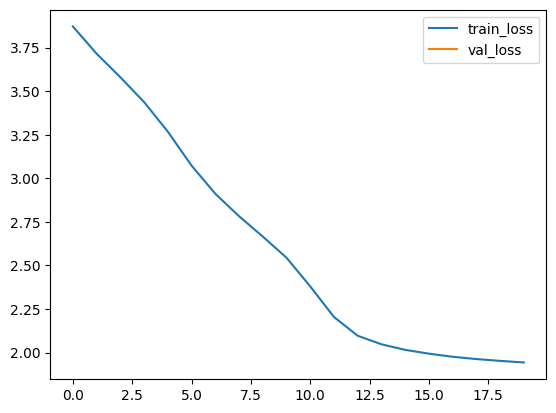

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5325 - loss: nan 
Test accuracy: 0.5355


In [ ]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=20,
    batch_size=64
)

# 查看 Loss 变化
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

# 简单测试集准确率
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_acc:.4f}")


In [ ]:
def predict_days_to_bloom(model, scaler, recent_weather):
    """
    recent_weather: (window_size, F) 的当日及之前天气数据
    返回值: 剩余天数的预测值
    """
    arr_2d = recent_weather.reshape(-1, len(FEATURE_COLS))
    arr_2d_scaled = scaler.transform(arr_2d)
    arr_3d = arr_2d_scaled.reshape(1, WINDOW_SIZE, len(FEATURE_COLS))

    prob = model.predict(arr_3d)[0]  # (num_classes,)
    pred_class = np.argmax(prob)
    return pred_class

# 选开始预测的日期
df_weather=df
df_2025_part = df_weather[
    (df_weather["year"] == 2025) &
    (df_weather["DOY"].between(38, 47))
].sort_values("DOY")

if len(df_2025_part) == WINDOW_SIZE:
    recent_weather_10days = df_2025_part[FEATURE_COLS].values
    days_left = predict_days_to_bloom(model, scaler, recent_weather_10days)
    print(f"预测距离开花还有 {days_left} 天")
else:
    print("没有足够的2025年3月数据来做预测示例")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
预测距离开花还有 39 天


然后这个目前的结果是开花日期：

从2月16开始的第39天 (3.27)

从2月17开始的第47天 (4.5)

我在想可以多预测几个然后得到一个区间？